<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code inspired from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [1]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 35.8 MB/s 
     |████████████████████████████████| 92.6 MB 73 kB/s 
     |████████████████████████████████| 125 kB 27.4 MB/s 
     |████████████████████████████████| 246 kB 23.4 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 367 kB 23.5 MB/s 
     |████████████████████████████████| 3.2 MB 24.3 MB/s 
     |████████████████████████████████| 1.4 MB 44.2 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29742 sha256=490c6e07b7707f194ebd7a7ba949ea3a139b51227c3799db88aaca5431d02023
  Stored in directory: /root/.cache/pip/wheels/93/17/b3/86db1d93e9dae198813aa79831b403e4844d67986cf93894b5
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417108 sha256=fc1b1e5b72f87fc3164ba02b26c45a1ae19e

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
#DATA_DIR = './data/CamVid/'

DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [10]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

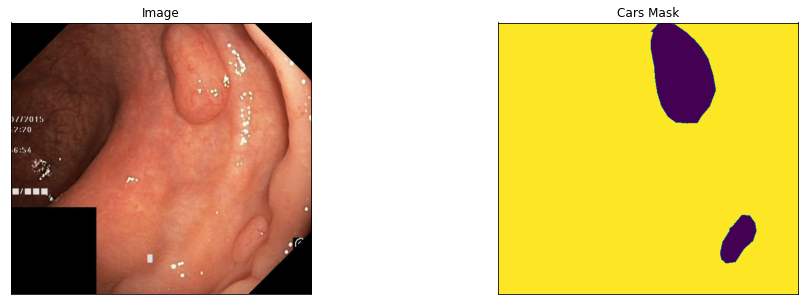

In [11]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        #albu.Resize(576, 736)
        albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [14]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['polyp', 'background']
ACTIVATION = 'sigmoid'

In [17]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [18]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please 

# Catalyst

## Training

In [19]:
import torch
import torch.nn as nn
from catalyst.dl.experiments import SupervisedRunner

# experiment setup
num_epochs = 10  # change me
logdir = "./logs/segmentation_notebook"
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

# model, criterion, optimizer
# model = # already defined
criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},  
])
scheduler = None

# @TODO: add metrics support 
# (catalyst expects logits, rather than sigmoid outputs)
# metrics = [
#     smp.utils.metrics.IoUMetric(eps=1.),
#     smp.utils.metrics.FscoreMetric(eps=1.),
# ]


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

0/10 * Epoch (train):   0% 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (train): 100% 100/100 [01:22<00:00,  1.22it/s, _fps=326.294, loss=0.509]
0/10 * Epoch (valid):   0% 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



0/10 * Epoch (valid): 100% 100/100 [00:40<00:00,  2.45it/s, _fps=71.277, loss=0.432]
[2022-11-02 12:46:31,273] 
0/10 * Epoch 0 (train): _fps=202.3488 | base/batch_time=0.4493 | base/data_time=0.3230 | base/lr=0.0010 | base/model_time=0.1263 | base/momentum=0.9000 | loss=0.5497
0/10 * Epoch 0 (valid): _fps=28.8350 | base/batch_time=0.3858 | base/data_time=0.3556 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.5273


INFO:metrics:
0/10 * Epoch 0 (train): _fps=202.3488 | base/batch_time=0.4493 | base/data_time=0.3230 | base/lr=0.0010 | base/model_time=0.1263 | base/momentum=0.9000 | loss=0.5497
0/10 * Epoch 0 (valid): _fps=28.8350 | base/batch_time=0.3858 | base/data_time=0.3556 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.5273


1/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.00it/s, _fps=219.142, loss=0.485]
1/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 24.90it/s, _fps=65.474, loss=0.550]
[2022-11-02 12:47:27,341] 
1/10 * Epoch 1 (train): _fps=161.0974 | base/batch_time=0.1401 | base/data_time=0.0913 | base/lr=0.0010 | base/model_time=0.0487 | base/momentum=0.9000 | loss=0.5417
1/10 * Epoch 1 (valid): _fps=40.3531 | base/batch_time=0.0300 | base/data_time=0.0108 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5289


INFO:metrics:
1/10 * Epoch 1 (train): _fps=161.0974 | base/batch_time=0.1401 | base/data_time=0.0913 | base/lr=0.0010 | base/model_time=0.0487 | base/momentum=0.9000 | loss=0.5417
1/10 * Epoch 1 (valid): _fps=40.3531 | base/batch_time=0.0300 | base/data_time=0.0108 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5289


2/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.03it/s, _fps=323.681, loss=0.491]
2/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.32it/s, _fps=59.321, loss=0.471]
[2022-11-02 12:48:23,929] 
2/10 * Epoch 2 (train): _fps=180.2298 | base/batch_time=0.1409 | base/data_time=0.0965 | base/lr=0.0010 | base/model_time=0.0442 | base/momentum=0.9000 | loss=0.5319
2/10 * Epoch 2 (valid): _fps=40.3427 | base/batch_time=0.0293 | base/data_time=0.0102 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5234


INFO:metrics:
2/10 * Epoch 2 (train): _fps=180.2298 | base/batch_time=0.1409 | base/data_time=0.0965 | base/lr=0.0010 | base/model_time=0.0442 | base/momentum=0.9000 | loss=0.5319
2/10 * Epoch 2 (valid): _fps=40.3427 | base/batch_time=0.0293 | base/data_time=0.0102 | base/lr=0.0010 | base/model_time=0.0191 | base/momentum=0.9000 | loss=0.5234


3/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.02it/s, _fps=303.693, loss=0.526]
3/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 24.53it/s, _fps=46.435, loss=0.496]
[2022-11-02 12:49:20,934] 
3/10 * Epoch 3 (train): _fps=180.2355 | base/batch_time=0.1410 | base/data_time=0.0972 | base/lr=0.0010 | base/model_time=0.0437 | base/momentum=0.9000 | loss=0.5309
3/10 * Epoch 3 (valid): _fps=38.8016 | base/batch_time=0.0305 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0200 | base/momentum=0.9000 | loss=0.5213


INFO:metrics:
3/10 * Epoch 3 (train): _fps=180.2355 | base/batch_time=0.1410 | base/data_time=0.0972 | base/lr=0.0010 | base/model_time=0.0437 | base/momentum=0.9000 | loss=0.5309
3/10 * Epoch 3 (valid): _fps=38.8016 | base/batch_time=0.0305 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0200 | base/momentum=0.9000 | loss=0.5213


4/10 * Epoch (train): 100% 100/100 [00:48<00:00,  2.07it/s, _fps=286.437, loss=0.522]
4/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.28it/s, _fps=67.240, loss=0.461]
[2022-11-02 12:50:15,335] 
4/10 * Epoch 4 (train): _fps=183.4618 | base/batch_time=0.1297 | base/data_time=0.0852 | base/lr=0.0010 | base/model_time=0.0445 | base/momentum=0.9000 | loss=0.5316
4/10 * Epoch 4 (valid): _fps=39.9857 | base/batch_time=0.0296 | base/data_time=0.0103 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5255


INFO:metrics:
4/10 * Epoch 4 (train): _fps=183.4618 | base/batch_time=0.1297 | base/data_time=0.0852 | base/lr=0.0010 | base/model_time=0.0445 | base/momentum=0.9000 | loss=0.5316
4/10 * Epoch 4 (valid): _fps=39.9857 | base/batch_time=0.0296 | base/data_time=0.0103 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5255


5/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.04it/s, _fps=324.072, loss=0.616]
5/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.41it/s, _fps=62.528, loss=0.553]
[2022-11-02 12:51:10,485] 
5/10 * Epoch 5 (train): _fps=170.3486 | base/batch_time=0.1407 | base/data_time=0.0984 | base/lr=0.0010 | base/model_time=0.0422 | base/momentum=0.9000 | loss=0.5291
5/10 * Epoch 5 (valid): _fps=39.8264 | base/batch_time=0.0296 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5254


INFO:metrics:
5/10 * Epoch 5 (train): _fps=170.3486 | base/batch_time=0.1407 | base/data_time=0.0984 | base/lr=0.0010 | base/model_time=0.0422 | base/momentum=0.9000 | loss=0.5291
5/10 * Epoch 5 (valid): _fps=39.8264 | base/batch_time=0.0296 | base/data_time=0.0104 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5254


6/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.01it/s, _fps=329.001, loss=0.545]
6/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.52it/s, _fps=64.151, loss=0.469]
[2022-11-02 12:52:07,600] 
6/10 * Epoch 6 (train): _fps=192.2056 | base/batch_time=0.1479 | base/data_time=0.1115 | base/lr=0.0010 | base/model_time=0.0362 | base/momentum=0.9000 | loss=0.5246
6/10 * Epoch 6 (valid): _fps=40.6352 | base/batch_time=0.0292 | base/data_time=0.0107 | base/lr=0.0010 | base/model_time=0.0185 | base/momentum=0.9000 | loss=0.5173


INFO:metrics:
6/10 * Epoch 6 (train): _fps=192.2056 | base/batch_time=0.1479 | base/data_time=0.1115 | base/lr=0.0010 | base/model_time=0.0362 | base/momentum=0.9000 | loss=0.5246
6/10 * Epoch 6 (valid): _fps=40.6352 | base/batch_time=0.0292 | base/data_time=0.0107 | base/lr=0.0010 | base/model_time=0.0185 | base/momentum=0.9000 | loss=0.5173


7/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.04it/s, _fps=277.234, loss=0.549]
7/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.71it/s, _fps=61.545, loss=0.517]
[2022-11-02 12:53:02,774] 
7/10 * Epoch 7 (train): _fps=179.8104 | base/batch_time=0.1402 | base/data_time=0.0978 | base/lr=0.0010 | base/model_time=0.0424 | base/momentum=0.9000 | loss=0.5250
7/10 * Epoch 7 (valid): _fps=40.7827 | base/batch_time=0.0289 | base/data_time=0.0094 | base/lr=0.0010 | base/model_time=0.0194 | base/momentum=0.9000 | loss=0.5292


INFO:metrics:
7/10 * Epoch 7 (train): _fps=179.8104 | base/batch_time=0.1402 | base/data_time=0.0978 | base/lr=0.0010 | base/model_time=0.0424 | base/momentum=0.9000 | loss=0.5250
7/10 * Epoch 7 (valid): _fps=40.7827 | base/batch_time=0.0289 | base/data_time=0.0094 | base/lr=0.0010 | base/model_time=0.0194 | base/momentum=0.9000 | loss=0.5292


8/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.04it/s, _fps=352.922, loss=0.514]
8/10 * Epoch (valid): 100% 100/100 [00:03<00:00, 25.39it/s, _fps=64.651, loss=0.560]
[2022-11-02 12:53:58,011] 
8/10 * Epoch 8 (train): _fps=184.6688 | base/batch_time=0.1384 | base/data_time=0.0938 | base/lr=0.0010 | base/model_time=0.0447 | base/momentum=0.9000 | loss=0.5234
8/10 * Epoch 8 (valid): _fps=40.3230 | base/batch_time=0.0291 | base/data_time=0.0099 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5209


INFO:metrics:
8/10 * Epoch 8 (train): _fps=184.6688 | base/batch_time=0.1384 | base/data_time=0.0938 | base/lr=0.0010 | base/model_time=0.0447 | base/momentum=0.9000 | loss=0.5234
8/10 * Epoch 8 (valid): _fps=40.3230 | base/batch_time=0.0291 | base/data_time=0.0099 | base/lr=0.0010 | base/model_time=0.0192 | base/momentum=0.9000 | loss=0.5209


9/10 * Epoch (train): 100% 100/100 [00:49<00:00,  2.03it/s, _fps=192.478, loss=0.482]
9/10 * Epoch (valid): 100% 100/100 [00:04<00:00, 20.03it/s, _fps=65.855, loss=0.489]
[2022-11-02 12:54:54,489] 
9/10 * Epoch 9 (train): _fps=177.0239 | base/batch_time=0.1358 | base/data_time=0.0874 | base/lr=0.0010 | base/model_time=0.0482 | base/momentum=0.9000 | loss=0.5245
9/10 * Epoch 9 (valid): _fps=33.9187 | base/batch_time=0.0388 | base/data_time=0.0121 | base/lr=0.0010 | base/model_time=0.0266 | base/momentum=0.9000 | loss=0.5187


INFO:metrics:
9/10 * Epoch 9 (train): _fps=177.0239 | base/batch_time=0.1358 | base/data_time=0.0874 | base/lr=0.0010 | base/model_time=0.0482 | base/momentum=0.9000 | loss=0.5245
9/10 * Epoch 9 (valid): _fps=33.9187 | base/batch_time=0.0388 | base/data_time=0.0121 | base/lr=0.0010 | base/model_time=0.0266 | base/momentum=0.9000 | loss=0.5187


Top best models:
logs/segmentation_notebook/checkpoints//train.6.pth	0.5173
logs/segmentation_notebook/checkpoints//train.9.pth	0.5187
logs/segmentation_notebook/checkpoints//train.8.pth	0.5209


### Visualization

In [20]:
from catalyst.dl.utils import UtilsFactory
# you can use plotly and tensorboard to plot metrics inside jupyter
# by default it only plots loss
# not sure if it correctly works in Colab
UtilsFactory.plot_metrics(logdir=logdir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

## Inference

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [22]:
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback
loaders = {"infer": test_dataloader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)

=> loading checkpoint "./logs/segmentation_notebook/checkpoints/best.pth"
loaded checkpoint "./logs/segmentation_notebook/checkpoints/best.pth" (epoch 6)
Top best models:



### Visualization

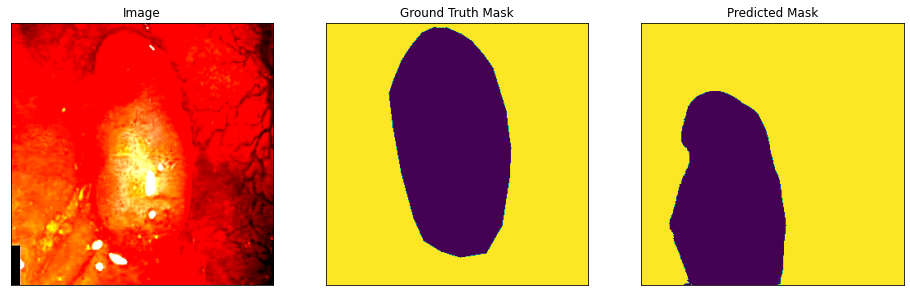

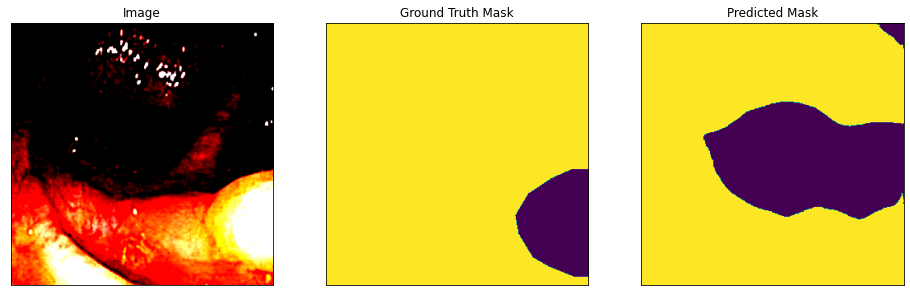

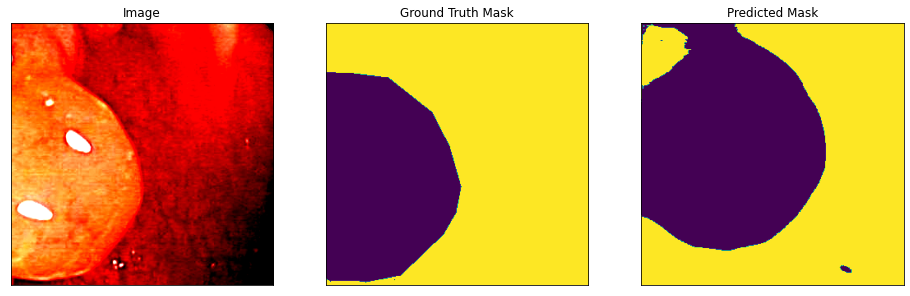

In [24]:
threshold = 0.5
break_at = 2

for i, (input, output) in enumerate(zip(
        test_dataset, runner.callbacks[1].predictions["logits"])):
    image, mask = input
    
    image_vis = image.transpose(1, 2, 0)
    gt_mask = mask[0].astype('uint8')
    pr_mask = (output[0] > threshold).astype('uint8')
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    if i >= break_at:
      break